In [1]:
!git clone https://github.com/susannapaoli/multimodal-memes.git

fatal: destination path 'multimodal-memes' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q transformers

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import json

sys.path.append('/content/multimodal-memes/GPT')
sys.path.append('/content/multimodal-memes/Utils')
sys.path.append('/content/multimodal-memes/JSON Data')

from dataloader import mydataset 
from plot_curves import plot_loss, plot_acc
from unimodal_trainer import train, validation

'''
For BERT
'''
from transformers import GPT2ForSequenceClassification, AdamW, GPT2Config
from transformers import get_linear_schedule_with_warmup


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


**Upload data**

In [6]:
%cd /content/multimodal-memes/JSON Data

/content/multimodal-memes/JSON Data


In [ ]:
#with open('train.jsonl', 'r') as f:
    #lines = f.readlines()

#split_idx = int(0.8*len(lines))
#train_lines = lines[:split_idx]
#val_lines = lines[split_idx:]

In [ ]:
#with open('training.json', 'w') as f:
  #for line in lines[:split_idx]:
   # f.write(line)

#with open('validation.json', 'w') as f:
  #for line in lines[split_idx:]:
    #f.write(line)


In [7]:
trainlist = 'train.jsonl'
validlist = 'test_seen.jsonl'

In [8]:
train_dataset = mydataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=16,pin_memory=True)
validation_dataset = mydataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 32, num_workers=16,pin_memory=True)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg

In [9]:
train_dataset[1]

("don't be afraid to love again everyone is not like your ex",
 tensor([ 9099,   470,   307,  7787,   284,  1842,   757,  2506,   318,   407,
           588,   534,   409, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(0))

**Model Definition**

In [14]:
model = GPT2ForSequenceClassification.from_pretrained(
    "gpt2", #12-layer BERT model, with an uncased vocab.
    num_labels = 2, #Binary classification
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.config.pad_token_id = model.config.eos_token_id
#model = model.to(device)
model = nn.DataParallel(model).to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Hyperparameters**

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
num_Epochs = 2
total_steps = len(train_dataloader) * num_Epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,  num_training_steps = total_steps)

In [16]:
modelname = 'GPT'
modelpath = './saved_model_checkpoints/'+modelname

In [20]:
writer = SummaryWriter(modelname)

train_loss, v_loss, v_acc = train(model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, modelpath, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.5829391038059292
Validation Loss: 0.7349	Validation Accuracy: 0.5870
Epoch:  2
training loss =  0.5288379017571757
Validation Loss: 0.7550	Validation Accuracy: 0.5930


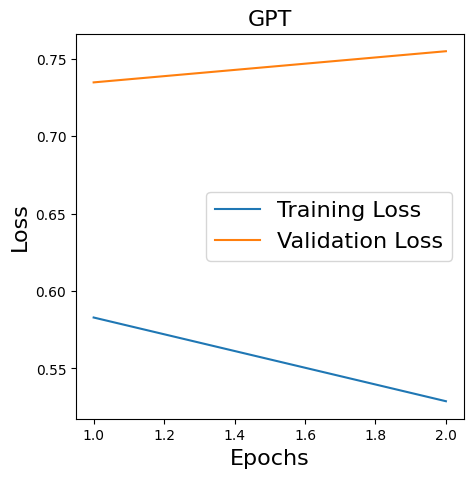

In [21]:
plot_loss(num_Epochs, train_loss, v_loss, 'GPT')

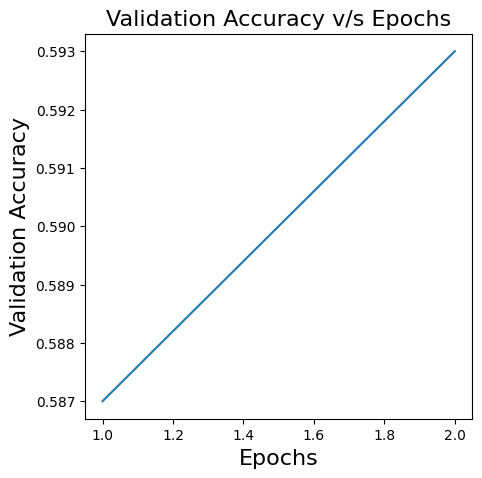

In [22]:
plot_acc(num_Epochs, v_acc)